In [23]:
import os, sys
import pandas as pd
import numpy as np
import datetime as dt
from pprint import pprint
import csv
import itertools as it
from prettytable import PrettyTable
import matplotlib.pylab as plt
import seaborn as sns
import portion as P
from collections import namedtuple
import math

pdir = os.path.abspath(os.path.join(os.getcwd(), '..'))  # for jupyter-notebook
sys.path.insert(1, pdir)
from myutils import *

%config InlineBackend.figure_format = 'retina'  # 提高 jupyter notebook 的圖形顯示解析度
# plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)
# pd.set_option('display.max_rows', 200)

DataFrame = namedtuple('DataFrame', 'filename, df', defaults=tuple([None]*2))

def set_data(df, mode='pcap', tz=0):
    if mode == 'pcap':
        df['seq'] = df['seq'].astype('Int32')
        # df['rpkg'] = df['rpkg'].astype('Int8')
        df['frame_id'] = df['frame_id'].astype('Int32')
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df['xmit_time'] = pd.to_datetime(df['xmit_time'])
        df['arr_time'] = pd.to_datetime(df['arr_time'])
        df['Timestamp_epoch'] = df['Timestamp_epoch'].astype('float32')
        df['xmit_time_epoch'] = df['xmit_time_epoch'].astype('float32')
        df['arr_time_epoch'] = df['arr_time_epoch'].astype('float32')
        df['lost'] = df['lost'].astype('boolean')
        df['excl'] = df['excl'].astype('boolean')
        df['latency'] = df['latency'].astype('float32')
    # E-UTRA & NR
    def nr_serv_cel(row):
        pos = row.serv_cel_pos
        if pos == 255:
            return 65535, -160, -50
        else:
            return row[f'PCI{pos}'], row[f'RSRP{pos}'], row[f'RSRQ{pos}']
    if mode == 'eutra':
        df = df.rename(columns={
            'RSRP(dBm)': 'RSRP',
            'RSRQ(dB)': 'RSRQ',
            'Serving Cell Index': 'serv_cel_index',
            'Number of Neighbor Cells': 'num_neigh_cels',
            'Number of Detected Cells': 'num_cels',
            }).reindex(['Timestamp','type_id','PCI','RSRP','RSRQ','serv_cel_index','EARFCN','NR_ARFCN',
                        'num_cels','num_neigh_cels','serv_cel_pos','PCI0','RSRP0','RSRQ0',
                        *df.columns.to_list()[df.columns.get_loc('PCI1'):]], axis=1)
        df.loc[df['serv_cel_index'] == '(MI)Unknown', 'serv_cel_index'] = '3_SCell'
        df['num_cels'] = df['num_neigh_cels'] + 1
        ## set dtypes
        df['Timestamp'] = pd.to_datetime(df['Timestamp']) + pd.Timedelta(hours=tz)
        df['type_id'] = df['type_id'].astype('category')
        df['serv_cel_index'] = df['serv_cel_index'].astype('category')
        df['EARFCN'] = df['EARFCN'].astype('Int32')
        df['NR_ARFCN'] = df['NR_ARFCN'].astype('Int32')
        df['num_cels'] = df['num_cels'].astype('UInt8')
        df['num_neigh_cels'] = df['num_neigh_cels'].astype('UInt8')
        df['serv_cel_pos'] = df['serv_cel_pos'].astype('UInt8')
        for tag in df.columns:
            if tag.startswith('PCI'):
                df[tag] = df[tag].astype('Int32')
            if tag.startswith(('RSRP','RSRQ')):
                df[tag] = df[tag].astype('float32')
    if mode == 'nr':
        if df.empty:
            df = pd.DataFrame(columns=['Timestamp','type_id','PCI','RSRP','RSRQ','serv_cel_index','EARFCN','NR_ARFCN',
                                       'num_cels','num_neigh_cels','serv_cel_pos','PCI0','RSRP0','RSRQ0'])
        else:
            df = df.rename(columns={
                'Raster ARFCN': 'NR_ARFCN',
                'Serving Cell Index': 'serv_cel_pos',
                'Num Cells': 'num_cels',
                }).reindex(['Timestamp','type_id','PCI','RSRP','RSRQ','serv_cel_index','EARFCN','NR_ARFCN',
                            'num_cels','num_neigh_cels','serv_cel_pos','PCI0','RSRP0','RSRQ0',
                            *df.columns.to_list()[df.columns.get_loc('PCI1'):]], axis=1)
            df.loc[df['serv_cel_pos'] != 255, 'serv_cel_index'] = 'PSCell'
            df[['PCI','RSRP','RSRQ']] = df.apply(nr_serv_cel, axis=1, result_type='expand')
            df.loc[df['serv_cel_pos'] == 255, 'num_neigh_cels'] = df['num_cels']
            df.loc[df['serv_cel_pos'] != 255, 'num_neigh_cels'] = df['num_cels'] - 1
        ## set dtypes
        df['Timestamp'] = pd.to_datetime(df['Timestamp']) + pd.Timedelta(hours=tz)
        df['type_id'] = df['type_id'].astype('category')
        df['serv_cel_index'] = df['serv_cel_index'].astype('category')
        df['EARFCN'] = df['EARFCN'].astype('Int32')
        df['NR_ARFCN'] = df['NR_ARFCN'].astype('Int32')
        df['num_cels'] = df['num_cels'].astype('UInt8')
        df['num_neigh_cels'] = df['num_neigh_cels'].astype('UInt8')
        df['serv_cel_pos'] = df['serv_cel_pos'].astype('UInt8')
        for tag in df.columns:
            if tag.startswith('PCI'):
                df[tag] = df[tag].astype('Int32')
            if tag.startswith(('RSRP','RSRQ')):
                df[tag] = df[tag].astype('float32')
    return df

In [24]:
coef_ul = pd.read_pickle('./coef_ul.pkl')
coef_dl = pd.read_pickle('./coef_dl.pkl')

In [25]:
coef_ul

,lower_bd,upper_bd,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70
LTE_HO,-2.0,2.0,-4.919807e-44,-9.340714e-44,6.900492e-42,2.600972e-42,-1.761507e-40,-3.041849e-40,-4.436411e-39,1.058707e-38,6.414119e-38,5.683956e-37,4.218243e-36,-4.961198e-37,4.666729e-35,-6.782997e-34,-1.779546e-33,-2.084367e-32,-7.096934e-32,3.316735e-32,-3.635997e-31,2.263226e-29,3.895790e-29,7.256083e-28,8.642385e-28,1.475407e-27,-1.946576e-26,-6.693665e-25,-1.088734e-24,-2.251840e-23,6.163972e-24,-2.560294e-23,1.535264e-21,2.114643e-20,2.520299e-20,5.821116e-19,-1.451360e-18,-6.593342e-18,-6.121278e-17,-7.000542e-16,7.588579e-16,-5.547025e-15,8.496307e-14,6.101741e-13,-2.429019e-13,9.660642e-12,-1.020883e-10,-5.967162e-10,9.927465e-10,-4.441739e-09,1.040274e-07,6.808589e-07,-4.387550e-06,-1.853813e-05,8.851702e-05,0.000281,-0.001113,-0.002776,0.009357,0.018651,-0.053284,-0.085736,0.201913,0.263171,-0.484004,-0.508411,0.660491,0.553295,-0.385864,-0.295028,-0.084717,0.115351,0.354114
NR_HO,-2.0,2.0,1.930852e-52,-1.034522e-50,-1.970656e-50,2.088785e-48,-7.015908e-49,-1.125961e-46,7.817385e-47,-1.997810e-45,3.596428e-45,1.952241e-43,-9.001941e-44,8.438015e-42,-1.299249e-41,-1.530782e-40,-3.589419e-40,-2.394560e-38,1.552541e-38,-6.158047e-37,1.678974e-36,2.824590e-35,4.701205e-35,2.651266e-33,-1.761483e-33,5.167434e-32,-2.066207e-31,-3.954752e-30,-6.034459e-30,-2.946355e-28,2.137691e-28,-2.933888e-27,2.488749e-26,5.937179e-25,5.878563e-25,2.936717e-23,-3.622856e-23,-4.570544e-22,-2.794761e-21,-8.606309e-20,-5.541693e-21,-9.484727e-19,6.520688e-18,1.991490e-16,1.488979e-16,4.223807e-15,-1.322291e-14,-5.132278e-13,-3.706722e-13,-3.459617e-12,3.188743e-11,1.444486e-09,-1.456444e-11,-6.787154e-08,-5.010783e-08,0.000002,0.000002,-0.000029,-0.000043,0.000319,0.000565,-0.002401,-0.004792,0.011884,0.026088,-0.036617,-0.087134,0.063533,0.163777,-0.051721,-0.157507,0.013251,0.194225
RLF,-4.5,3.0,-1.691187e-51,1.286946e-50,2.533900e-49,-1.470438e-48,-6.720177e-48,-2.352102e-47,-4.023681e-46,4.302457e-45,3.205314e-45,2.218018e-43,7.414048e-43,-3.382057e-42,1.756862e-41,-8.443658e-40,-4.790484e-40,-3.490749e-38,-2.476971e-38,6.246454e-37,7.612146e-37,1.420047e-34,2.081375e-35,6.229669e-33,-8.204351e-33,-8.015412e-32,-6.498625e-31,-2.367316e-29,2.193559e-30,-1.046416e-27,3.173030e-27,1.848752e-26,1.731580e-25,4.190099e-24,-3.791791e-24,1.366095e-22,-8.707467e-22,-7.486493e-21,-2.272589e-20,-7.126468e-19,2.483217e-18,2.220634e-18,1.561344e-16,2.363711e-15,-6.263821e-15,2.398251e-14,-6.258533e-13,-7.817232e-12,2.725960e-11,2.648613e-11,1.650284e-09,2.584858e-08,-1.784164e-07,-1.577646e-06,7.445105e-06,0.000050,-0.000187,-0.001032,0.003106,0.014388,-0.035299,-0.138035,0.272775,0.897779,-1.386619,-3.804173,4.306405,9.769431,-6.913545,-13.323646,3.046522,6.976481,3.278685
NR_Setup,-0.5,2.0,7.609456e-24,-4.250583e-23,-4.304988e-23,1.835397e-22,8.632944e-22,1.678472e-21,-2.811150e-22,-1.503170e-20,-6.405410e-20,-1.640315e-19,-2.136102e-19,4.159900e-19,3.910675e-18,1.555350e-17,4.234700e-17,7.234566e-17,-1.791915e-17,-7.499920e-16,-3.668683e-15,-1.193379e-14,-2.761973e-14,-3.217503e-14,8.977791e-14,7.626183e-13,3.107257e-12,8.932358e-12,1.703650e-11,4.021735e-12,-1.395573e-10,-7.544858e-10,-2.541402e-09,-5.809816e-09,-5.368030e-09,2.818968e-08,1.926537e-07,6.910989e-07,1.573398e-06,1.079841e-06,-9.912072e-06,-5.801275e-05,-1.789513e-04,-2.724522e-04,4.923774e-04,4.881052e-03,1.666395e-02,2.339976e-02,-6.754655e-02,-5.037823e-01,-1.258321e+00,4.947629e-01,1.446183e+01,4.015884e+01,-3.778550e+01,-513.881419,-561.151935,4945.145067,9454.826631,-80918.604256,176191.900114,-176310.259061,53774.916774,53417.996961,-51507.664866,6250.104019,8850.175739,-2832.240032,-490.617597,229.018589,8.706988,-4.203222,1.598583


In [26]:
coef_dl

,lower_bd,upper_bd,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70
LTE_HO,-2.0,2.0,-3.444771e-44,1.162487e-42,-7.991951e-42,-3.122363e-41,3.321365e-40,-6.009565e-40,8.299821e-39,-2.160823e-38,-7.270734e-38,-1.603783e-37,-7.478111e-36,2.919129e-35,-1.685259e-34,1.455240e-33,-7.094495e-34,2.352984e-32,7.234416e-32,-7.000175e-31,3.133574e-30,-5.169957e-29,9.629433e-29,-1.213714e-27,2.310143e-27,7.494341e-27,1.584759e-27,1.454002e-24,-3.528003e-24,4.220455e-23,-1.746672e-22,-1.399255e-23,-2.541932e-21,-4.014649e-20,1.371136e-19,-1.133162e-18,7.908123e-18,7.501402e-18,6.015577e-17,1.207761e-15,-8.260758e-15,1.684726e-14,-2.363207e-13,-8.195557e-13,6.688543e-12,-2.314626e-11,3.293660e-10,6.141269e-10,-8.571531e-09,1.687929e-08,-2.901501e-07,-7.111377e-07,1.782443e-05,6.446832e-06,-4.179768e-04,0.000095,0.005864,-0.003101,-0.054461,0.038051,0.345186,-0.269964,-1.490286,1.186708,4.269969,-3.190537,-7.703279,4.905141,8.056050,-3.789455,-4.635600,1.218711,2.000008
NR_HO,-3.5,4.0,1.144078e-51,2.986887e-50,-2.328597e-49,-6.409286e-48,1.258512e-47,3.807067e-46,2.242038e-46,4.912177e-45,-2.128533e-44,-7.090714e-43,-9.462417e-43,-2.551355e-41,1.382651e-41,7.740454e-40,2.530594e-39,8.523483e-38,7.475028e-38,1.633926e-36,-2.260455e-36,-1.293694e-34,-2.676095e-34,-9.565966e-33,-7.323721e-33,-1.188148e-31,2.572146e-31,1.779023e-29,2.802810e-29,1.074197e-27,6.774071e-28,2.302719e-27,-3.284244e-26,-2.563197e-24,-2.811219e-24,-1.037819e-22,-3.443405e-23,2.811756e-21,4.789681e-21,3.479358e-19,2.098714e-19,1.612729e-18,-4.598820e-18,-8.611022e-16,-4.655168e-16,-1.296224e-14,4.161689e-15,2.242658e-12,6.459963e-13,4.279176e-12,-1.338781e-11,-6.079414e-09,4.569618e-10,3.041556e-07,-6.088255e-08,-0.000008,0.000003,0.000138,-0.000085,-0.001565,0.001383,0.011973,-0.014240,-0.059832,0.092756,0.182829,-0.370049,-0.293065,0.853551,0.123453,-1.089040,0.198807,0.911759
RLF,-5.5,2.0,-8.882916e-51,3.027764e-50,1.616014e-48,-2.557015e-48,-6.594662e-47,-2.174819e-46,-2.708849e-45,1.342083e-44,9.576807e-44,1.094048e-42,8.793753e-42,-3.639828e-42,8.643710e-41,-3.745812e-39,-1.781946e-38,-1.783366e-37,-9.792899e-37,2.444747e-36,1.345633e-36,7.075780e-34,2.578083e-33,3.206154e-32,1.130333e-31,-4.602034e-31,-1.831456e-30,-1.287232e-28,-3.856502e-28,-5.541005e-27,-1.089558e-26,1.241981e-25,6.639995e-25,2.420394e-23,5.533559e-23,7.291123e-22,-1.678295e-22,-4.808174e-20,-1.710362e-19,-4.208330e-18,-3.293241e-18,2.713685e-17,4.806818e-16,1.465076e-14,1.364730e-14,1.156580e-13,-1.569681e-12,-4.918569e-11,-1.597649e-11,2.295778e-10,5.452036e-09,1.614435e-07,-2.586719e-07,-9.866713e-06,6.136692e-06,0.000310,-0.000072,-0.006144,0.000023,0.081492,0.012640,-0.728394,-0.197747,4.293904,1.538136,-15.852201,-6.798955,33.311272,17.682039,-33.517895,-30.373859,11.031880,37.230237
NR_Setup,-0.5,2.0,2.647644e-23,-1.402540e-22,-1.670420e-22,5.333104e-22,2.835329e-21,6.208876e-21,2.222922e-21,-4.138638e-20,-2.024429e-19,-5.774719e-19,-9.745110e-19,3.465889e-19,1.023537e-17,4.743029e-17,1.453697e-16,3.064823e-16,2.448851e-16,-1.519730e-15,-9.985468e-15,-3.739739e-14,-1.012952e-13,-1.800013e-13,1.919249e-16,1.655553e-12,8.551205e-12,2.884637e-11,6.961515e-11,9.087157e-11,-1.800687e-10,-1.769711e-09,-7.358793e-09,-2.090180e-08,-3.697493e-08,9.820338e-09,3.965673e-07,1.880069e-06,5.539599e-06,9.332418e-06,-7.236734e-06,-1.231341e-04,-5.130349e-04,-1.216651e-03,-6.755746e-04,8.595757e-03,4.419528e-02,1.064022e-01,1.571882e-02,-9.643707e-01,-3.842100e+00,-4.571119e+00,2.194216e+01,1.132565e+02,1.005179e+02,-881.063157,-2677.323303,5390.677493,31041.905039,-92494.889038,10141.921178,297398.596693,-525877.487420,370058.465369,-39396.912495,-98679.649130,49104.511412,1393.591260,-5502.442454,590.876890,191.054763,-40.544092,19.614251


In [27]:
def heaviside(x, left, right):
    
    if x < left:
        return 0
    elif x > right:
        return 0
    else:
        return 1

def poly_approx(x_list, type, center=0, mode='ul'):
    
    if center == None:
        p = np.poly1d(0)
        return p(x_list)
    
    if mode == 'ul':
        _coef = list(coef_ul.loc[type])
    else: # mode == 'dl'
        _coef = list(coef_dl.loc[type])
        
    x_list = [x - center for x in x_list]
    lower_bd = _coef[0]
    upper_bd = _coef[1]
    coef = _coef[2:]
    p = np.poly1d(coef)
    
    return np.clip(p(x_list)*np.vectorize(heaviside)(x_list, lower_bd, upper_bd), a_min=0, a_max=100)

# Scenario

- radio1: 1s 後發生 NR HO
- radio2: 3s 後發生 RLF
- 預測 1, 2, 3, 4, 5s 後的 packet loss rate

沒發生：None
HO有發生：X sec
RLF, Setup 發生：2 sec

Radio1: {'LTE_HO': None,
         'NR_HO': 4,
         'RLF': None,
         'NR_Setup': 2}

0-1s: 0.16 %
1-2s: 0.17 %
2-3s: 0.13 %
3-4s: 0.0 %
4-5s: 0.0 %


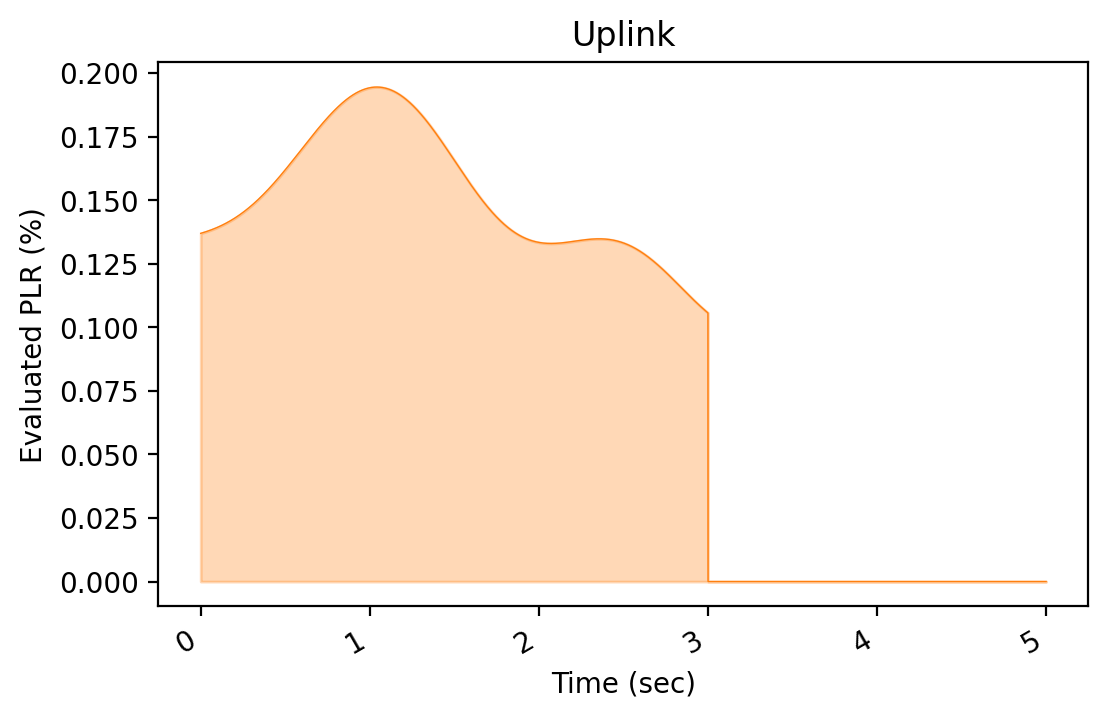

In [28]:
SPR = 5000
duration = 5 # seconds; 1,000 samples per second
x = [s/SPR for s in list(range(1, 5*SPR+1))]

y = poly_approx(x, 'NR_HO', center=1)
# y2 = poly_approx(x, 'RLF', center=3)
# y = [s1*s2/100 for (s1, s2) in zip(y1, y2)]
# y = [s if s <= 100 else 100 for s in y]

for i in range(duration):
    print(f'{i}-{i+1}s:', round(np.mean(y[i*SPR:(i+1)*SPR]), 2), '%')

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, y, '-', c='tab:orange', lw=0.5)
ax.fill_between(x, y, color='tab:orange', alpha=0.3)
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Evaluated PLR (%)')
ax.set_title('Uplink')
plt.gcf().autofmt_xdate()
plt.show()

0-1s: 0.0 %
1-2s: 0.0 %
2-3s: 0.0 %
3-4s: 0.0 %
4-5s: 0.0 %


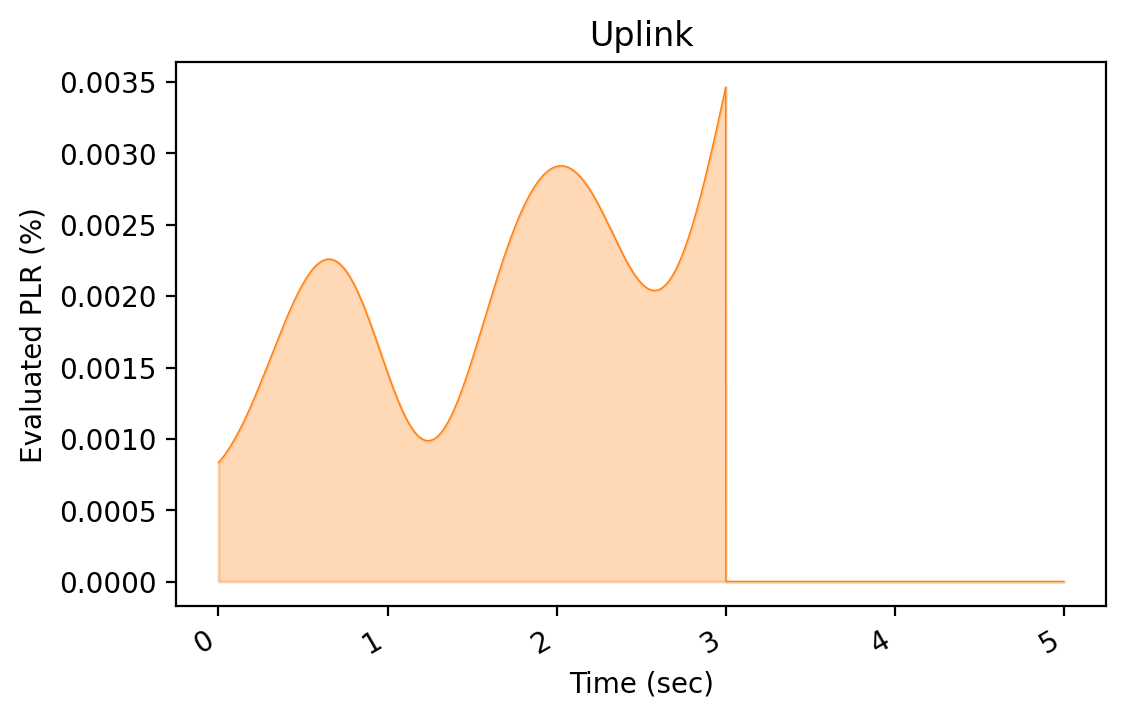

In [29]:
SPR = 5000
duration = 5 # seconds; 1,000 samples per second
x = [s/SPR for s in list(range(1, 5*SPR+1))]

y1 = poly_approx(x, 'NR_HO', center=1)
y2 = poly_approx(x, 'RLF', center=3)
y = [s1*s2/100 for (s1, s2) in zip(y1, y2)]
# y = [s if s <= 100 else 100 for s in y]

for i in range(duration):
    print(f'{i}-{i+1}s:', round(np.mean(y[i*SPR:(i+1)*SPR]), 2), '%')

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, y, '-', c='tab:orange', lw=0.5)
ax.fill_between(x, y, color='tab:orange', alpha=0.3)
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Evaluated PLR (%)')
ax.set_title('Uplink')
plt.gcf().autofmt_xdate()
plt.show()

0-1s: 0.0 %
1-2s: 0.0 %
2-3s: 0.0 %
3-4s: 0.0 %
4-5s: 0.0 %


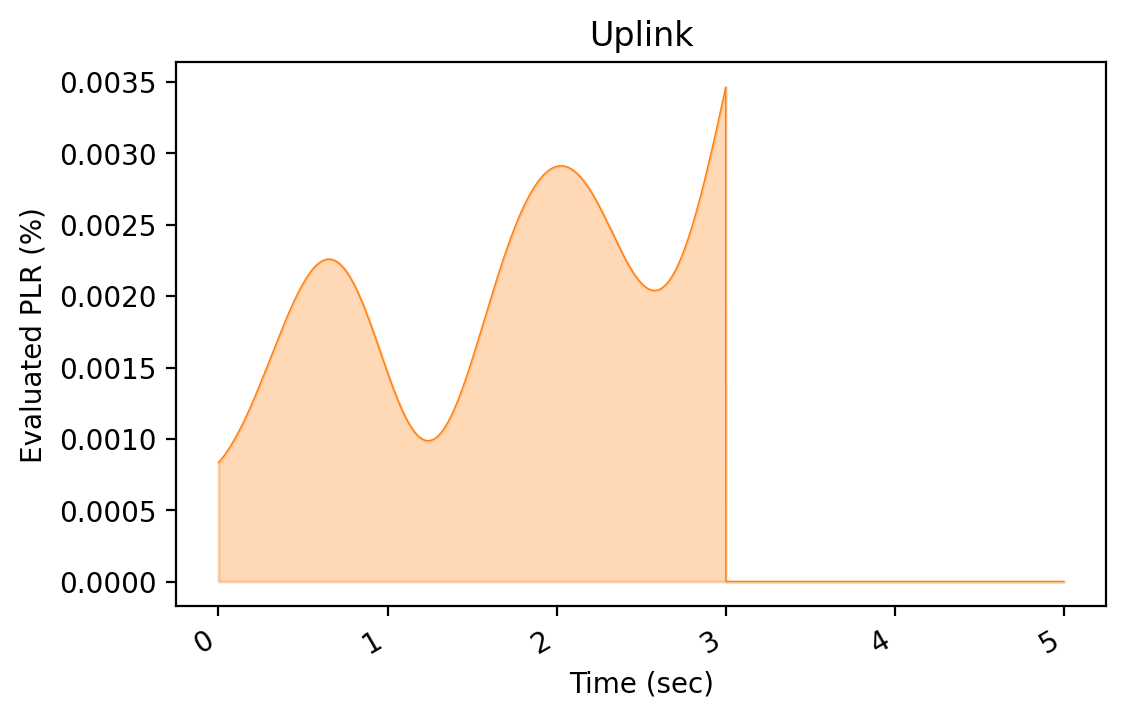

In [30]:
SPR = 5000
duration = 5 # seconds; 1,000 samples per second
x = [s/SPR for s in list(range(1, 5*SPR+1))]

y1 = poly_approx(x, 'NR_HO', center=1)
y2 = poly_approx(x, 'RLF', center=3)
y = [s1*s2/100 for (s1, s2) in zip(y1, y2)]
# y = [s if s <= 100 else 100 for s in y]

for i in range(duration):
    print(f'{i}-{i+1}s:', round(np.mean(y[i*SPR:(i+1)*SPR]), 2), '%')

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, y, '-', c='tab:orange', lw=0.5)
ax.fill_between(x, y, color='tab:orange', alpha=0.3)
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Evaluated PLR (%)')
ax.set_title('Uplink')
plt.gcf().autofmt_xdate()
plt.show()

0-1s: 0.58 %
1-2s: 0.77 %
2-3s: 0.38 %
3-4s: 0.15 %
4-5s: 0.16 %


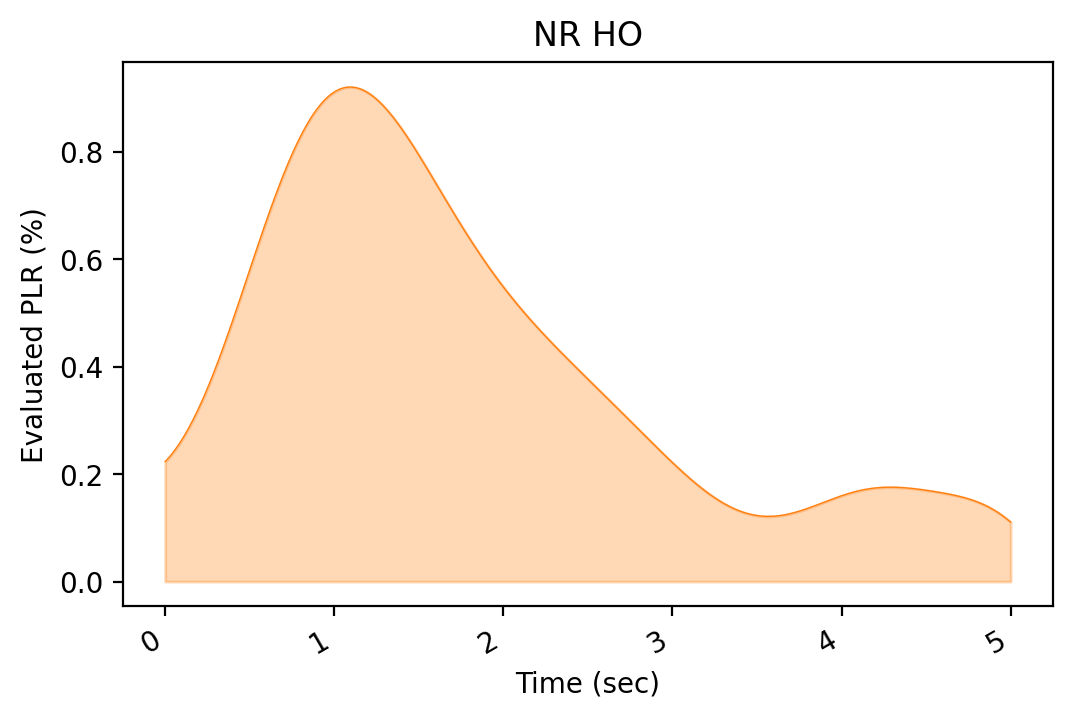

In [31]:
SPR = 5000
duration = 5 # seconds; 1,000 samples per second
x = [s/SPR for s in list(range(1, 5*SPR+1))]

y = poly_approx(x, 'NR_HO', center=1, mode='dl')
# y2 = poly_approx(x, 'RLF', center=3, mode='dl')
# y = [s1*s2/100 for (s1, s2) in zip(y1, y2)]
# y = [s if s <= 100 else 100 for s in y]

for i in range(duration):
    print(f'{i}-{i+1}s:', round(np.mean(y[i*SPR:(i+1)*SPR]), 2), '%')

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, y, '-', c='tab:orange', lw=0.5)
ax.fill_between(x, y, color='tab:orange', alpha=0.3)
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Evaluated PLR (%)')
ax.set_title('NR HO')
plt.gcf().autofmt_xdate()
plt.show()

0-1s: 4.56 %
1-2s: 10.51 %
2-3s: 28.75 %
3-4s: 30.9 %
4-5s: 11.02 %


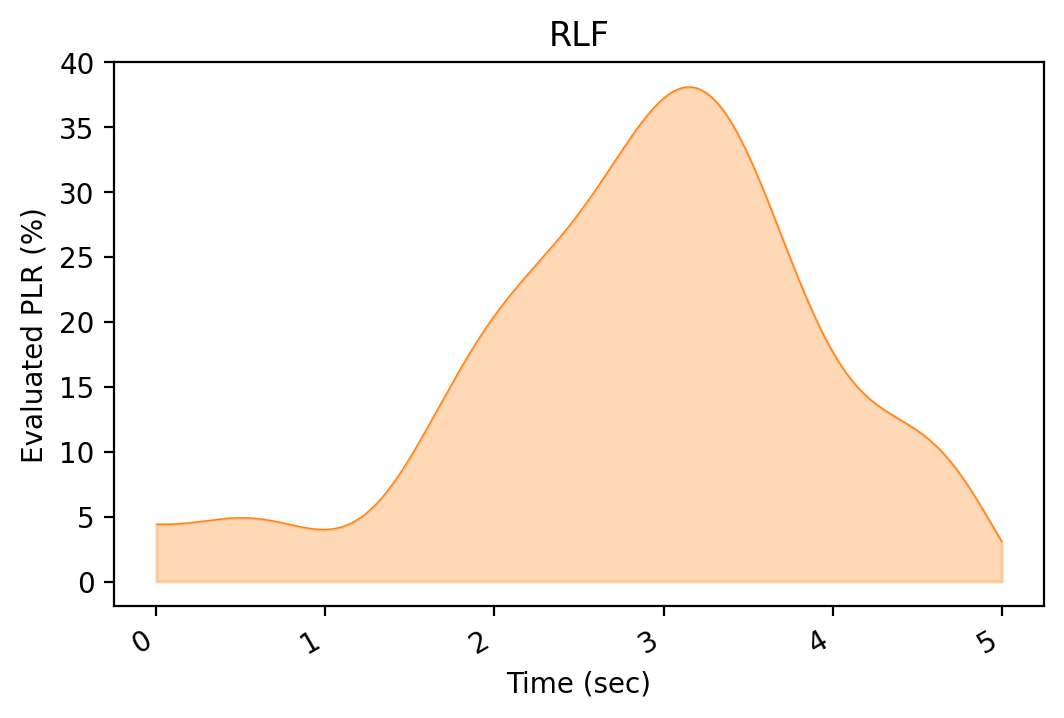

In [32]:
SPR = 5000
duration = 5 # seconds; 1,000 samples per second
x = [s/SPR for s in list(range(1, 5*SPR+1))]

# y1 = poly_approx(x, 'NR_HO', center=1, mode='dl')
y = poly_approx(x, 'RLF', center=3, mode='dl')
# y = [s1*s2/100 for (s1, s2) in zip(y1, y2)]
# y = [s if s <= 100 else 100 for s in y]

for i in range(duration):
    print(f'{i}-{i+1}s:', round(np.mean(y[i*SPR:(i+1)*SPR]), 2), '%')

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, y, '-', c='tab:orange', lw=0.5)
ax.fill_between(x, y, color='tab:orange', alpha=0.3)
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Evaluated PLR (%)')
ax.set_title('RLF')
plt.gcf().autofmt_xdate()
plt.show()

0-1s: 0.03 %
1-2s: 0.07 %
2-3s: 0.1 %
3-4s: 0.05 %
4-5s: 0.02 %


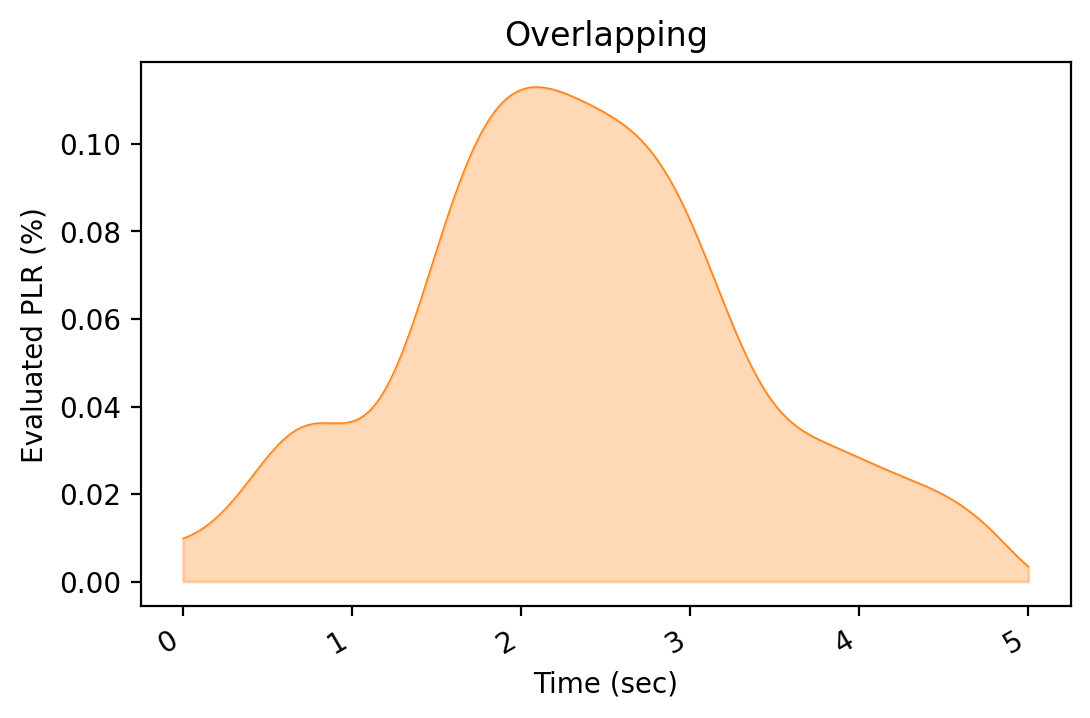

In [33]:
SPR = 5000
duration = 5 # seconds; 1,000 samples per second
x = [s/SPR for s in list(range(1, 5*SPR+1))]

y1 = poly_approx(x, 'NR_HO', center=1, mode='dl')
y2 = poly_approx(x, 'RLF', center=3, mode='dl')
y = [s1*s2/100 for (s1, s2) in zip(y1, y2)]
# y = [s if s <= 100 else 100 for s in y]

for i in range(duration):
    print(f'{i}-{i+1}s:', round(np.mean(y[i*SPR:(i+1)*SPR]), 2), '%')

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, y, '-', c='tab:orange', lw=0.5)
ax.fill_between(x, y, color='tab:orange', alpha=0.3)
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Evaluated PLR (%)')
ax.set_title('Overlapping')
plt.gcf().autofmt_xdate()
plt.show()

In [34]:
from collections import namedtuple
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

### Read Coefficients
coef_ul = pd.read_pickle('./coef_ul.pkl')
coef_dl = pd.read_pickle('./coef_dl.pkl')

### Function
def evaluate_plr(radio1, radio2, predict_time=10, spr=5000, show_fig=False):
    
    def heaviside(x, left, right):
    
        if x < left:
            return 0
        elif x > right:
            return 0
        else:
            return 1

    def poly_approx(x_list, type, center=0, mode='ul'):
        
        if center == None:
            p = np.poly1d(0)
            return p(x_list)
        
        if mode == 'ul':
            _coef = list(coef_ul.loc[type])
        else: # mode == 'dl'
            _coef = list(coef_dl.loc[type])
            
        x_list = [x - center for x in x_list]
        lower_bd = _coef[0]
        upper_bd = _coef[1]
        coef = _coef[2:]
        p = np.poly1d(coef)
        
        return np.clip(p(x_list)*np.vectorize(heaviside)(x_list, lower_bd, upper_bd), a_min=0, a_max=100)
    
    OP = namedtuple('Output', 'ul, dl', defaults=(None, None))
    
    eval_plr = []
    eval_plr1 = []
    eval_plr2 = []
    
    x = [s/spr for s in list(range(1, predict_time * spr + 1))]
    for mode in ['ul', 'dl']:
        Y1 = []
        Y2 = []
        for tag in ['LTE_HO', 'NR_HO', 'RLF', 'NR_Setup']:
            y1 = poly_approx(x, 'NR_HO', center=radio1[tag], mode=mode)
            y2 = poly_approx(x, 'RLF', center=radio2[tag], mode=mode)
            Y1.append(y1)
            Y2.append(y2)
        y1 = [s1+s2+s3+s4 if s1+s2+s3+s4 <= 100 else 100 for (s1, s2, s3, s4) in zip(Y1[0],Y1[1],Y1[2],Y1[3])]
        y2 = [s1+s2+s3+s4 if s1+s2+s3+s4 <= 100 else 100 for (s1, s2, s3, s4) in zip(Y2[0],Y2[1],Y2[2],Y2[3])]
        y = [s1*s2/100 for (s1, s2) in zip(y1, y2)]
        eval_plr.append(round(np.mean(y), 2))
        eval_plr1.append(round(np.mean(y1), 2))
        eval_plr2.append(round(np.mean(y2), 2))

        if show_fig:
            fig, ax = plt.subplots(figsize=(4.5, 4))
            ax.plot(x, y, '-', c='tab:orange', lw=0.5)
            ax.fill_between(x, y, color='tab:orange', alpha=0.3)
            ax.set_xlabel('Time (sec)')
            ax.set_ylabel('Evaluated PLR (%)')
            if mode == 'ul':
                ax.set_title('Uplink')
            else:    
                ax.set_title('Downlink')

    return OP(eval_plr[0], eval_plr[1]), OP(eval_plr1[0], eval_plr1[1]), OP(eval_plr2[0], eval_plr2[1])

Output(ul=0.0, dl=0.09) Output(ul=0.12, dl=0.45) Output(ul=2.07, dl=17.26)


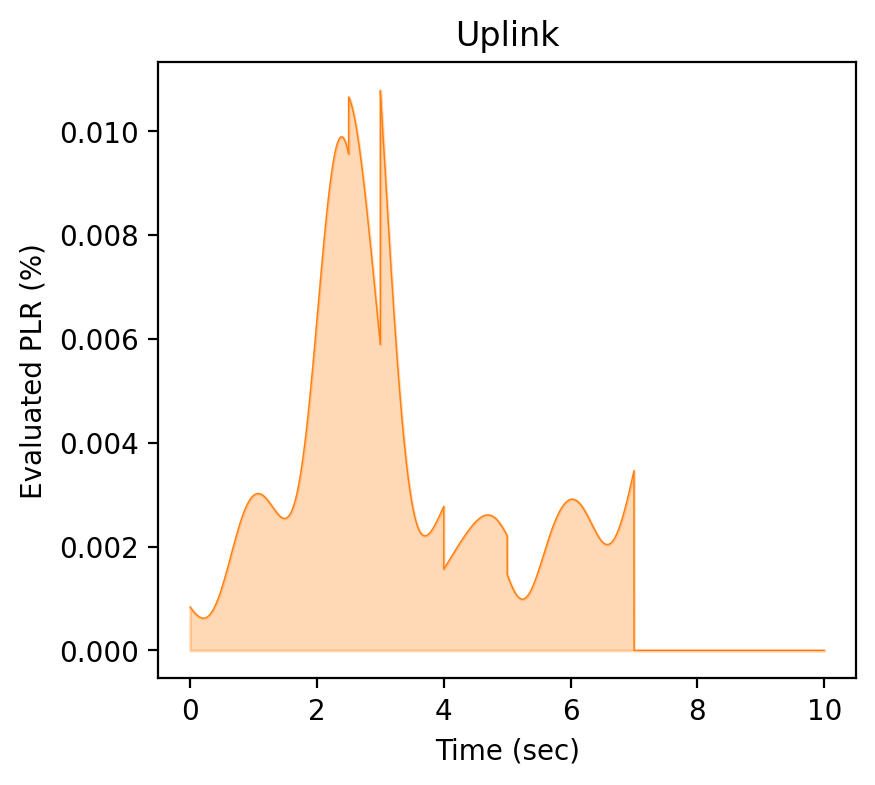

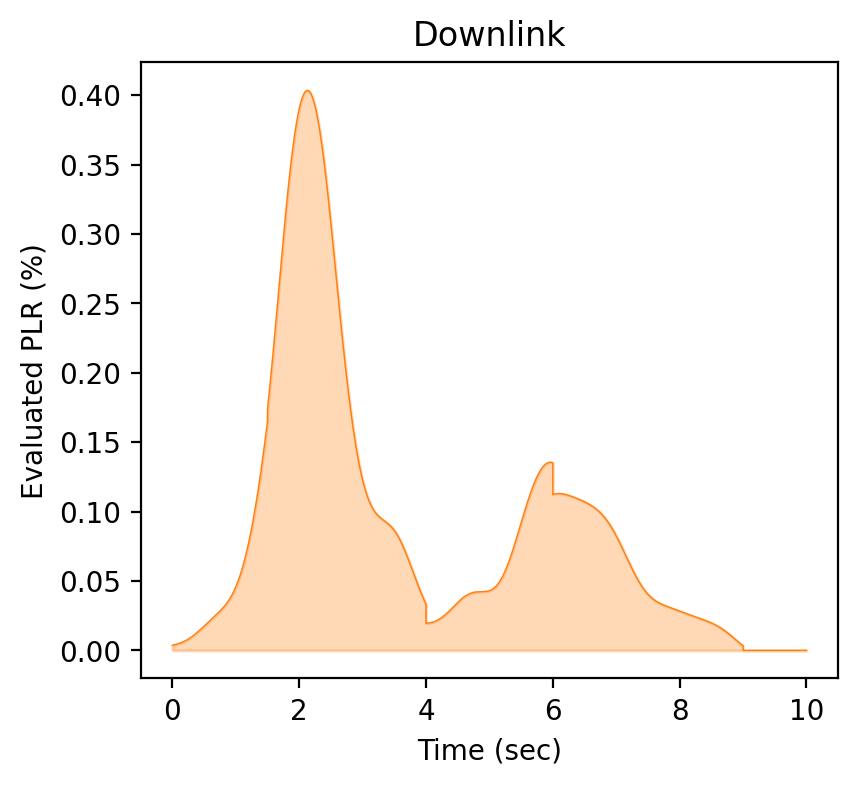

In [35]:
### Example
radio1 = { 'LTE_HO': None, 'NR_HO': 5,    'RLF': None, 'NR_Setup': 2 } 
radio2 = { 'LTE_HO': 7,    'NR_HO': None, 'RLF': 2,    'NR_Setup': None }

eval_plr, eval_plr1, eval_plr2 = evaluate_plr(radio1, radio2, predict_time=10, show_fig=True)
print(eval_plr, eval_plr1, eval_plr2)